In [3]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

def coupling_operator_with_phase(i, j, dim, phi):

    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):

    # if not (0 <= f <= 1):
    #     raise ValueError("Fraction f must be between 0 and 1.")
    theta = np.pi*np.array(f)#2.0 * np.arcsin(np.sqrt(f))
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):

    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq
    
def fix_couplings_and_phases(couplings, fixed_phase_flags):
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl
        if i != 0 and j == 0:
            cpl_fixed = (0, i)
            
            phase_flag_fixed = phase_flag + 1.0
        else:
            cpl_fixed = cpl
            phase_flag_fixed = phase_flag
        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags
    
def decompose_unitary_with_givens(U_target, connection_map, tol=1e-10):
    dim = U_target.shape[0]
    U_working = U_target.copy()
    Givens_sequence = []

    for col in range(dim):
        for row in reversed(range(col+1, dim)):
            i, j = row-1, row
            if (i, j) not in connection_map and (j, i) not in connection_map:
                continue  # Skip if not allowed by the connection map

            a = U_working[i, col]
            b = U_working[j, col]

            if abs(b) < tol:
                continue

            r = np.sqrt(abs(a)**2 + abs(b)**2)
            c = a / r
            s = b / r
            phi = np.angle(-s) - np.angle(c)
            theta = 2 * np.arcsin(np.abs(s))

            # Calculate fraction f for theta = pi*f
            f = theta / np.pi

            # Determine fixed_phase_flag from phi (0 or 1 or something in between)
            # Simplify to either 0.0 or 0.5 for now, depending on sign
            fix_pflag = 0.5 * (1 - np.sign(np.real(np.exp(1j * phi))))

            # Apply Givens rotation to the left of U_working (unitary similarity)
            G = np.eye(dim, dtype=complex)
            G[i, i] = np.conj(c)
            G[i, j] = np.conj(s)
            G[j, i] = -s
            G[j, j] = c

            U_working = G @ U_working

            # Append to sequence
            Givens_sequence.append(((i, j), 1.0, f, fix_pflag))  # Assuming Omega = 1

    return Givens_sequence


In [22]:
# Example unitary (must be unitary!)
# from scipy.linalg import qr
# np.random.seed(0)
# U_rand, _ = qr(np.random.randn(3,3) + 1j*np.random.randn(3,3))

dim =3
init_state = np.array([0,1,0])
couplings = [(2,0),(0,1),(2,0)]
fractions = [1,1/2,1]#[np.sin(1)**2]  
rabi_freqs = [1,1,1]      
fixed_phase_flags = [0.5,0.5,0.5]  

couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
# print(couplings, fixed_phase_flags)
U_rand = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
print(np.round(U_rand,3))

[[-1.   +0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.707-0.j  0.707-0.j]
 [ 0.   +0.j  0.707+0.j -0.707+0.j]]


In [18]:

connection_map = [(0,1), (0,2)]
decomp = decompose_unitary_with_givens(U_rand, connection_map)

couplings = [d[0] for d in decomp]
fractions = [d[2] for d in decomp]
fixed_phase_flags = [d[3] for d in decomp]
rabi_freqs = [1] * len(couplings)
print(couplings,fractions)
couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
U_check = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim=3)

print()
print("Reconstruction fidelity:", np.abs(np.trace(U_check.conj().T @ U_rand)) / 3)


[] []

Reconstruction fidelity: 0.3333333333333333


In [57]:
import numpy as np
from scipy.linalg import expm
import warnings

# --- User Provided Functions (with slight modifications for direct use) ---
def coupling_operator_with_phase(i, j, dim, phi):
    """Creates the Hamiltonian term for a coupling with phase."""
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    """Calculates pulse duration t based on fraction f and Rabi freq Omega."""
    # The angle theta in expm(-i * H * t) is Omega * t / 2 for the standard SU(2) rotation.
    # The user's unitary function implies the angle in the exponent is H_coupling * t_pulse.
    # H_coupling = 0.5 * Omega * H_op.
    # The rotation angle in the resulting matrix is theta = Omega * t_pulse.
    # User defined theta = pi * f.
    # So, Omega * t_pulse = pi * f => t_pulse = pi * f / Omega
    theta = np.pi*np.array(f)
    return theta / Omega if Omega != 0 else 0.0

def get_givens_rotation(k, l, dim, fraction, fixed_phase_flag, rabi_freq=1.0):
    """Generates a single Givens rotation matrix U_pulse."""
    if rabi_freq == 0:
        return np.eye(dim, dtype=complex)

    # Ensure k < l for convention, adjust phase flag if swapped
    if k > l:
      k, l = l, k
      # Adjusting phase might depend on specific definitions,
      # Assuming standard physics convention based on user's H_op:
      # H(k,l,phi) = 0.5*Omega*(e^{i*phi}|k><l| + e^{-i*phi}|l><k|)
      # Swapping k,l gives H(l,k,phi) = 0.5*Omega*(e^{i*phi}|l><k| + e^{-i*phi}|k><l|)
      # This is H(k,l,-phi). So flip the sign of the phase angle.
      fixed_phase_flag = -fixed_phase_flag # Needs careful check based on user convention

    phi_fixed = fixed_phase_flag * np.pi
    H_op = coupling_operator_with_phase(k, l, dim, phi_fixed)
    H_coupling = 0.5 * rabi_freq * H_op
    t_pulse = pulse_duration_for_fraction(fraction, rabi_freq)
    U_pulse = expm(-1j * H_coupling * t_pulse)
    return U_pulse

# --- Decomposition Function ---

def calculate_givens_parameters(a, b):
    """
    Calculates fraction (f) and fixed_phase_flag (p) for a Givens rotation
    G = get_givens_rotation(k, l, dim, f, p) such that applying G to a matrix
    zeros out the element corresponding to 'b' using element 'a'.

    Args:
        a (complex): The diagonal element U[k, k] or pivot element.
        b (complex): The off-diagonal element U[l, k] to be zeroed (l > k).

    Returns:
        tuple: (fraction, fixed_phase_flag) or None if b is already zero.
    """
    if np.abs(b) < 1e-15: # Threshold for already being zero
        return None

    a_conj = np.conjugate(a)
    b_conj = np.conjugate(b)
    r = np.sqrt(np.abs(a)**2 + np.abs(b)**2)

    # Parameters for the rotation matrix G that performs the zeroing:
    # G = [[c*, s*], [-s, c]] where c=a/r, s=b/r in standard numerical linear algebra.
    # We need to find f, p such that our U_pulse matches G.
    # U_pulse(k, l) = [[C, S], [S*, C]] where C=cos(T/2), S=-i*exp(iP)*sin(T/2)
    # T = pi*f, P = pi*p
    # We are applying G from the left. The matrix G we need is:
    # G = [[a_conj/r, b_conj/r], [-b/r, a/r]] to zero out b in [a, b]^T column vector.

    # Comparing G with U_pulse:
    # C = a_conj / r  => cos(T/2) = a_conj / r
    # S = b_conj / r  => -i*exp(iP)*sin(T/2) = b_conj / r
    # S* = -b / r     => i*exp(-iP)*sin(T/2) = -b / r (Checks out if first two hold)
    # C = a / r       => cos(T/2) = a / r

    # Requires a=a_conj (a is real). This approach doesn't directly map.

    # --- Alternative approach: Find G such that G @ U zeroes U[l, k] ---
    # Let G = U_pulse(k, l, f, p). We apply G to rows k and l.
    # We look at column k: [a], [b] (where a = U[k, k], b = U[l, k])
    # After applying G:
    # New element at (k, k) = C*a + S*b
    # New element at (l, k) = S*.conj()*a + C*b = S*a + C*b  (since C is real)
    # We want S*a + C*b = 0
    # -i*exp(iP)*sin(T/2)*a + cos(T/2)*b = 0
    # cos(T/2)*b = i*exp(iP)*sin(T/2)*a
    # cot(T/2) = i * exp(iP) * (a / b)
    # Let z = i * a / b = R * exp(i * alpha)
    # cot(T/2) = R * exp(i*alpha) * exp(iP) = R * exp(i*(alpha + P))

    # Since cot(T/2) must be real and non-negative (0 <= T/2 <= pi/2):
    # 1. The phase must cancel: exp(i*(alpha + P)) must be real (+1).
    #    alpha + P = 2 * m * pi for integer m. Choose m=0 => P = -alpha.
    # 2. cot(T/2) = R
    if np.abs(b) < 1e-15: # Avoid division by zero
         return None

    z = 1j * a / b
    R = np.abs(z)
    alpha = np.angle(z)

    # Calculate Phase (P)
    P = -alpha
    fixed_phase_flag = P / np.pi
    # Normalize phase flag to be in a standard range if desired, e.g., [0, 2) or [-1, 1)
    # fixed_phase_flag = np.mod(fixed_phase_flag, 2.0) # Example: [0, 2)
    # fixed_phase_flag = (fixed_phase_flag + 1) % 2 - 1 # Example: [-1, 1)

    # Calculate Angle (T)
    # Ensure R is not excessively large (can happen if b is near zero)
    if R > 1e15: # If R is huge, T/2 is tiny, cot(T/2) ~ 2/T
        T_over_2 = np.arctan(1.0 / R) # Use arctan for numerical stability
    else:
        T_over_2 = np.arccos(R / np.sqrt(1 + R**2)) # arccot(R) = arccos(R / sqrt(1+R^2))
        # Or directly T_over_2 = np.arctan(1/R) if using arccot definition

    T = 2 * T_over_2
    fraction = T / np.pi

    # Handle edge case T=0 (fraction=0) -> identity, b should have been ~0
    if abs(fraction) < 1e-15:
        return None

    return fraction, fixed_phase_flag


def unitary_decomposition_qr(u_target, connection_map, dim):
    """
    Decomposes a target unitary U_target into a sequence of Givens rotations
    using a QR-like method, respecting the connection map.

    Args:
        u_target (np.ndarray): The target unitary matrix (dim x dim).
        connection_map (list or set): A list or set of allowed tuples (i, j)
                                      for Givens rotations (0 <= i < j < dim).
        dim (int): The dimension of the unitary matrix.

    Returns:
        list: A list of tuples, where each tuple represents a Givens rotation:
              (coupling=(k, l), fraction, rabi_freq=1.0, fixed_phase_flag).
              Returns None if decomposition fails due to connection constraints.
        np.ndarray: The remaining diagonal matrix D such that the sequence G_n*...G_1*U = D.
                    Ideally, D is I or I * exp(i*phase).
    """
    if not isinstance(u_target, np.ndarray) or u_target.shape != (dim, dim):
        raise ValueError(f"u_target must be a {dim}x{dim} numpy array.")
    if not np.allclose(u_target @ u_target.conj().T, np.eye(dim)):
         warnings.warn("Input matrix u_target might not be unitary.", UserWarning)

    # Ensure connection map allows lookups in both orders (i,j) and (j,i)
    allowed_connections = set()
    for conn in connection_map:
        i, j = min(conn), max(conn)
        if i != j:
            allowed_connections.add((i, j))

    u_current = u_target.copy()
    applied_rotations_G = [] # Stores parameters for G_k

    # --- QR-like elimination loop ---
    # Zero out elements below the main diagonal, column by column
    for k in range(dim - 1):  # Column index k
        for l in range(dim - 1, k, -1): # Row index l (l > k)
            # Target element to zero: u_current[l, k]
            # Pivot element: u_current[k, k]
            # We need a rotation G acting on rows k and l.

            # Check if the required coupling (k, l) is allowed
            if (k, l) not in allowed_connections:
                # If the direct rotation is not allowed, this simple QR method fails.
                # More advanced methods might use intermediate swaps if possible.
                 if np.abs(u_current[l, k]) > 1e-10: # Only fail if it's not already zero
                    print(f"Decomposition failed: Required coupling ({k}, {l}) not in connection map to zero element ({l},{k}).")
                    print(f"Value of element ({l},{k}) is {u_current[l, k]}")
                    # You might want to raise an error or return None, depending on desired behavior
                    # raise RuntimeError(f"Decomposition failed: Required coupling ({k}, {l}) not in connection map.")
                    return None, None # Indicate failure

            # Calculate parameters for G_k such that G_k @ U zeroes U[l, k]
            a = u_current[k, k]
            b = u_current[l, k]

            params = calculate_givens_parameters(a, b)

            if params is not None:
                f, p = params
                # Store parameters for the rotation G_k
                applied_rotations_G.append(((k, l), f, 1.0, p))

                # Apply the rotation G_k to the left of u_current
                Gk = get_givens_rotation(k, l, dim, f, p, rabi_freq=1.0)
                u_current = Gk @ u_current
                # print(f"Applied G({k},{l}), f={f:.3f}, p={p:.3f}. Element ({l},{k}) = {u_current[l, k]:.2e}") # Debugging

            # Small numerical errors might remain, explicitly zero them
            if abs(u_current[l, k]) > 1e-12:
                # warnings.warn(f"Element ({l},{k}) did not zero out completely: {u_current[l, k]}", UserWarning)
                pass # It might be zeroed out by later rotations or is numerically unstable
            u_current[l, k] = 0.0 # Force zero for stability

    # --- Final Sequence Calculation ---
    # At this point, u_current should be diagonal (D)
    # We have G_n @ ... @ G_1 @ U_target = D
    # So U_target = G_1^† @ ... @ G_n^† @ D
    # The sequence should be the parameters for G_n^†, ..., G_1^†

    final_sequence = []
    for params_Gk in reversed(applied_rotations_G):
        coupling, f, rabi, p = params_Gk
        # Calculate parameters for G_k^† = inverse(G_k)
        # Inverse of U_pulse(k, l, f, p) is U_pulse(k, l, f, p') where p' = -p - 1
        p_inv = -p - 1.0
        # Normalize p_inv if needed, e.g., to [-1, 1)
        # p_inv = (p_inv + 1) % 2 - 1

        final_sequence.append((coupling, f, rabi, p_inv))

    return final_sequence, u_current # u_current is the remaining diagonal D

# --- Helper function to reconstruct U from sequence ---
# (Using user's original unitary function for verification)
def reconstruct_unitary(sequence, dim):
    """Reconstructs the unitary using the user's original function."""
    U_reconstructed = np.eye(dim, dtype=complex)

    couplings = [item[0] for item in sequence]
    fractions = [item[1] for item in sequence]
    rabi_freqs = [item[2] for item in sequence]
    fixed_phase_flags = [item[3] for item in sequence]

    # Apply pulses in the order they are listed
    # User's function: U = Pulse_N @ ... @ Pulse_1 @ Eye
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels # Assumes k < l from decomposition output
        phi_fixed = fix_pflag * np.pi
        H_op = coupling_operator_with_phase(i, j, dim, phi_fixed)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_reconstructed = U_pulse @ U_reconstructed

    return U_reconstructed


# --- Example Usage ---

# Define the target unitary (example: SWAP gate on 0,1 in 3D)
# dim = 3
# u_target = np.array([
#     [0, 1, 0],
#     [1, 0, 0],
#     [0, 0, 1]
# ], dtype=complex)

# Or use the unitary from the user's example
dim = 3
couplings_in = [(0,2),(0,1),(0,2)] # Note: User provided (2,0), (0,1), (2,0) - fixed order here
fractions_in = [1, 1/2, 1]
rabi_freqs_in = [1, 1, 1]
fixed_phase_flags_in = [0.5+1, 0.5, 0.5+1] # User provided 0.5,0.5,0.5 and fixed (2,0) -> (0,2) with phase+1

print("--- Input Unitary ---")
print("Couplings:", couplings_in)
print("Fractions:", fractions_in)
print("Rabi Freqs:", rabi_freqs_in)
print("Phase Flags:", fixed_phase_flags_in)

# Reconstruct the target using user's convention for verification
U_target = np.eye(dim, dtype=complex)
for (levels, Omega, frac, fix_pflag) in zip(couplings_in, rabi_freqs_in, fractions_in, fixed_phase_flags_in):
    i, j = levels
    phi_fixed = fix_pflag * np.pi
    H_op = coupling_operator_with_phase(i, j, dim, phi_fixed)
    H_coupling = 0.5 * Omega * H_op
    t_pulse = pulse_duration_for_fraction(frac, Omega)
    U_pulse = expm(-1j * H_coupling * t_pulse)
    U_target = U_pulse @ U_target # Apply in order

print("\nTarget Unitary U_target:")
print(np.round(U_target, 3))

# Define the allowed connections (e.g., fully connected)
connection_map = []
for i in range(dim):
    for j in range(i + 1, dim):
        connection_map.append((i, j))
print("\nConnection Map:", connection_map)
connection_map = [(0,1),(0,2)]
# --- Perform Decomposition ---
print("\n--- Decomposition ---")
sequence, D = unitary_decomposition_qr(U_target, connection_map, dim)

if sequence is not None:
    print(f"Decomposition successful. Found {len(sequence)} rotations.")
    # print("\nSequence (coupling, fraction, rabi_freq, fixed_phase_flag):")
    # for item in sequence:
    #     print(f"  {item[0]}, {item[1]:.4f}, {item[2]}, {item[3]:.4f}")

    print("\nRemaining diagonal matrix D:")
    print(np.round(D, 3))

    # Check if D is identity up to a global phase
    diag_elements = np.diag(D)
    first_diag = diag_elements[0]
    diag_normalized = diag_elements / first_diag
    identity_normalized = np.ones(dim, dtype=complex)
    if np.allclose(diag_normalized, identity_normalized):
        print("Remaining matrix D is Identity (up to global phase).")
        print(f"(Global phase factor approx: {first_diag:.3f})")
    else:
        print("WARNING: Remaining matrix D is not Identity (up to global phase).")
        print("The sequence reconstructs U_target @ D^dagger.")
        print("Diagonal elements relative to first:", np.round(diag_normalized, 3))


    # --- Verification ---
    print("\n--- Verification ---")
    U_reconstructed = reconstruct_unitary(sequence, dim)
    print("Reconstructed Unitary U_reconstructed:")
    print(np.round(U_reconstructed, 3))

    # Compare U_reconstructed with U_target
    # They should be equal if D was identity (up to global phase)
    # Otherwise, U_reconstructed should be approx U_target @ D.conj().T

    # Calculate U_target @ D.conj().T for comparison if D is not identity
    U_target_times_D_dagger = U_target @ D.conj().T
    # Extract the global phase from the target for a cleaner comparison
    phase_factor = np.angle(U_target[0,0]) # or average phase
    U_rec_normalized = U_reconstructed * np.exp(-1j*phase_factor)
    U_target_normalized = U_target * np.exp(-1j*phase_factor)
    U_target_D_dag_normalized = U_target_times_D_dagger * np.exp(-1j*phase_factor)

    diff_target = np.linalg.norm(U_reconstructed - U_target)
    diff_target_D_dag = np.linalg.norm(U_reconstructed - U_target_times_D_dagger)

    print(f"\n|| U_reconstructed - U_target || = {diff_target:.2e}")
    print(f"|| U_reconstructed - (U_target @ D^dagger) || = {diff_target_D_dag:.2e}")

    if diff_target < 1e-9:
        print("Reconstructed matches Target (up to numerical precision).")
    elif diff_target_D_dag < 1e-9:
        print("Reconstructed matches Target @ D^dagger (up to numerical precision).")
    else:
        print("Reconstruction does not closely match Target or Target @ D^dagger.")

else:
    print("Decomposition failed. Check connection map or input unitary.")

--- Input Unitary ---
Couplings: [(0, 2), (0, 1), (0, 2)]
Fractions: [1, 0.5, 1]
Rabi Freqs: [1, 1, 1]
Phase Flags: [1.5, 0.5, 1.5]

Target Unitary U_target:
[[-1.   +0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.707-0.j  0.707-0.j]
 [ 0.   +0.j  0.707+0.j -0.707+0.j]]

Connection Map: [(0, 1), (0, 2), (1, 2)]

--- Decomposition ---
Decomposition failed: Required coupling (1, 2) not in connection map to zero element (2,1).
Value of element (2,1) is (0.7071067811865475+8.659560562354933e-17j)
Decomposition failed. Check connection map or input unitary.


[(0, 2), (0, 1), (0, 2), (0, 4), (0, 3), (0, 1), (0, 3), (0, 2), (0, 4), (0, 6), (0, 5), (0, 6), (0, 8), (0, 7), (0, 5), (0, 7), (0, 6), (0, 2), (0, 6), (0, 5), (0, 1), (0, 5), (0, 7), (0, 3), (0, 7), (0, 4), (0, 8)] [1.5, 0.5, 1.5, 1.5, 1.5, 0.5, 1.5, 0.5, 1.5, 1.5, 0.5, 1.5, 1.5, 1.5, 0.5, 1.5, 1.5, 0.5, 1.5, 1.5, 0.5, 1.5, 1.5, 0.5, 1.5, 0.5, 1.5]
[[ 0.354+0.j  0.354+0.j  0.354+0.j  0.354+0.j  0.354+0.j  0.354+0.j
   0.354+0.j  0.354+0.j]
 [ 0.354+0.j -0.354+0.j  0.354+0.j -0.354+0.j  0.354+0.j -0.354+0.j
   0.354+0.j -0.354+0.j]
 [ 0.354+0.j  0.354+0.j -0.354+0.j -0.354+0.j  0.354+0.j  0.354+0.j
  -0.354+0.j -0.354+0.j]
 [ 0.354+0.j -0.354+0.j -0.354+0.j  0.354+0.j  0.354+0.j -0.354+0.j
  -0.354+0.j  0.354+0.j]
 [ 0.354+0.j  0.354+0.j  0.354+0.j  0.354+0.j -0.354+0.j -0.354+0.j
  -0.354+0.j -0.354+0.j]
 [ 0.354+0.j -0.354+0.j  0.354+0.j -0.354+0.j -0.354+0.j  0.354+0.j
  -0.354+0.j  0.354+0.j]
 [ 0.354+0.j  0.354+0.j -0.354+0.j -0.354+0.j -0.354+0.j -0.354+0.j
   0.354+0.j  0.354+0

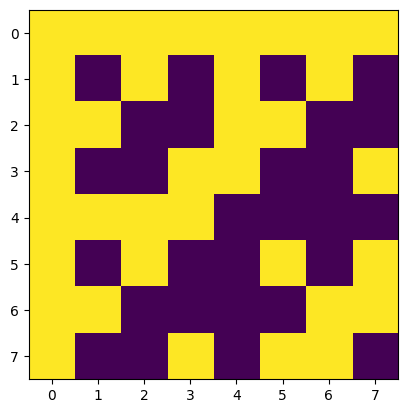

|| (Q @ R) - A || = 1.4905545222651586e-15


In [44]:
import numpy as np
import math # Use math.hypot for numerical stability
from scipy.linalg import expm
import matplotlib.pyplot as plt
def qr_decomposition_givens(A):
    """
    Performs QR decomposition of matrix A using Givens rotations.

    Args:
        A (np.ndarray): The input matrix (m x n).

    Returns:
        list: A list of tuples representing the Givens rotations applied.
              Each tuple is (j, i, c, s), where j and i are the row indices
              (i > j) and c, s are the rotation parameters such that the
              applied rotation matrix G has:
              G[j, j] = c.conjugate()
              G[j, i] = s.conjugate()
              G[i, j] = -s
              G[i, i] = c
        np.ndarray: The resulting upper triangular matrix R.
    """
    m, n = A.shape
    R = A.copy().astype(complex) # Work with complex numbers
    rotations = []

    for j in range(n): # Iterate through columns
        for i in range(m - 1, j, -1): # Iterate through rows below diagonal (bottom-up)
            # Target element to zero: R[i, j]
            # Pivot element: R[j, j] (although we use R[i-1, j] in the common algorithm variant)

            # Let's use the standard approach targeting R[i, j] using R[j, j]
            pivot_row_idx = j
            target_row_idx = i

            a = R[pivot_row_idx, j] # Element in pivot row
            b = R[target_row_idx, j] # Element to zero

            if np.abs(b) < 1e-15: # Tolerance for zero
                continue # Skip rotation if element is already zero

            # Calculate Givens rotation parameters c, s
            # r = math.hypot(abs(a), abs(b)) # sqrt(|a|^2 + |b|^2) - use np.hypot for complex
            r = np.hypot(np.abs(a), np.abs(b))

            # Check for potential division by zero if r is zero (only if a and b are zero)
            if r < 1e-15:
                continue

            c = a / r
            s = b / r

            # Store the parameters for this rotation G
            # G acts on rows pivot_row_idx (j) and target_row_idx (i)
            rotations.append((pivot_row_idx, target_row_idx, c, s))

            # Apply the rotation G to the rows of R efficiently
            # G = [[c*, s*], [-s, c]]
            # New row j = c* * (row j) + s* * (row i)
            # New row i = -s * (row j) + c * (row i)

            # We apply this transformation to columns k >= j
            for k in range(j, n):
                x = R[pivot_row_idx, k]
                y = R[target_row_idx, k]
                R[pivot_row_idx, k] = c.conjugate() * x + s.conjugate() * y
                R[target_row_idx, k] = -s * x + c * y

            # Explicitly set the zeroed element for numerical stability
            R[target_row_idx, j] = 0.0


    # --- Optional: Construct Q ---
    # Q = G_1^H @ G_2^H @ ... @ G_k^H
    # Start with Q = I and apply the conjugate transposes in reverse order
    # Q = np.eye(m, dtype=complex)
    # for k in range(len(rotations) - 1, -1, -1):
    #     j, i, c, s = rotations[k]
    #     # Apply G_k^H to Q
    #     # Gk^H = [[c, -s*], [s, c*]] acting on rows j, i
    #     for col in range(m):
    #         x = Q[j, col]
    #         y = Q[i, col]
    #         Q[j, col] = c * x - s.conjugate() * y
    #         Q[i, col] = s * x + c.conjugate() * y

    return rotations, R # Optionally return Q as well

def coupling_operator_with_phase(i, j, dim, phi):

    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):

    # if not (0 <= f <= 1):
    #     raise ValueError("Fraction f must be between 0 and 1.")
    theta = np.pi*np.array(f)#2.0 * np.arcsin(np.sqrt(f))
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):

    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def fix_couplings_and_phases(couplings, fixed_phase_flags):
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl
        if i != 0 and j == 0:
            cpl_fixed = (0, i)
            
            phase_flag_fixed = phase_flag + 1.0
        else:
            cpl_fixed = cpl
            phase_flag_fixed = phase_flag
        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags

# dim = 5
# init_state = np.array([0,0,1,0,0])
# couplings = [(0, 2), (0, 3), (0, 1), (0, 4), (0, 1), (0, 3), (0, 2)]
# fractions = [1, 1.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 2/3, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 0.5, 1]
# fixed_phase_flags = [0, 1, 0, 1, 0, 1, 1]
# rabi_freqs = [1,1,1,1,1,1,1]

dim = 9
init_state = np.array([0,1,0,0,0,0,0,0,0])
couplings = [(2,0),(0,1),(2,0)] + [(4,0),(3,0)]  + [(0,1),(3,0)] + [(0,2),(4,0)]\
          + [(6,0),(0,5),(6,0)] + [(8,0),(7,0)]  + [(0,5),(7,0)] + [(6,0)]\
          + [(0,2),(6,0)] + [(5,0),(0,1),(5,0)] + [(7,0),(0,3),(7,0)] + [(0,4),(8,0)]
fractions = [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2,1]\
          + [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2]\
          + [1/2,1] + [1,1/2,1] + [1,1/2,1] + [1/2,1]
rabi_freqs = [1,1,1]+[1,1]+[1,1]+[1,1]\
           + [1,1,1]+[1,1]+[1,1]+[1,1]\
           +[1,1]+[1,1,1]+[1,1,1]+[1,1,1]
fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5,0.5]\
                   +[0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5]\
                   + [0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5]


couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
print(couplings, fixed_phase_flags)
A2 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)

A2 = np.array([[0.354-0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,
   0.354+0.j,  0.354+0.j,  0.354+0.j],
 [0.354-0.j, -0.354+0.j,  0.354+0.j, -0.354-0.j,  0.354+0.j,
  -0.354-0.j,  0.354+0.j, -0.354-0.j],
 [0.354-0.j,  0.354-0.j, -0.354-0.j, -0.354+0.j,  0.354+0.j,
   0.354+0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j,  0.354+0.j,
  -0.354-0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j,  0.354-0.j,  0.354-0.j,  0.354-0.j, -0.354-0.j,
  -0.354-0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j, -0.354+0.j,
   0.354+0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j, 0.354-0.j, -0.354+0.j, -0.354+0.j, -0.354+0.j,
  -0.354+0.j,  0.354+0.j, 0.354+0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j,
   0.354+0.j,  0.354+0.j, -0.354+0.j]],  dtype=complex)

# dim = 3
# H = (1/np.sqrt(2)) * np.array([[np.sqrt(2),0,0],[0,1, 1], [0,1, -1]])
# P = np.array([[1, 0,0], [0, 1,0],[0,0,1]])
# A2 = H @ P
# print("Input Matrix A:")
print(np.round(A2, 3))

# Perform QR decomposition using Givens rotations
givens_params, R_matrix = qr_decomposition_givens(A2)

print("\nNumber of Givens rotations:", len(givens_params))
print("\nGivens Rotation Parameters (j, i, c, s):")
# Limiting printout for brevity if many rotations
for i, params in enumerate(givens_params[:]): # Print first 10
    j, i_row, c, s = params
    print(f"  G{i+1}: rows=({j}, {i_row}), c={np.round(c,3)}, s={np.round(s,3)}")
if len(givens_params) > 10:
    print("  ...")

print("\nResulting Upper Triangular Matrix R:")
print(np.round(R_matrix, 3))

# --- Verification (Optional) ---
print("\n--- Verification ---")
# 1. Reconstruct the product of Givens rotations G = G_k @ ... @ G_1
G_total = np.eye(A2.shape[0], dtype=complex)
for params in givens_params:
    j, i, c, s = params
    G_k = np.eye(A2.shape[0], dtype=complex)
    G_k[j, j] = c.conjugate()
    G_k[j, i] = s.conjugate()
    G_k[i, j] = -s
    G_k[i, i] = c
    G_total = G_k @ G_total

# 2. Check if G_total @ A is close to R
R_reconstructed = G_total @ A2
print("|| (G_k @ ... @ G_1 @ A) - R || =", np.linalg.norm(R_reconstructed - R_matrix))

# 3. Construct Q = G_1^H @ ... @ G_k^H
Q_reconstructed = np.eye(A2.shape[0], dtype=complex)
for params in reversed(givens_params):
    j, i, c, s = params
    Gk_H = np.eye(A2.shape[0], dtype=complex)
    # Gk^H has c on diag, -s* at (j,i), s at (i,j)
    Gk_H[j, j] = c
    Gk_H[j, i] = -s.conjugate()
    Gk_H[i, j] = s
    Gk_H[i, i] = c.conjugate()
    Q_reconstructed = Gk_H @ Q_reconstructed

# 4. Check if Q @ R is close to A
A_reconstructed = Q_reconstructed @ R_matrix
plt.imshow(np.real(Q_reconstructed))
plt.show()
print("|| (Q @ R) - A || =", np.linalg.norm(A_reconstructed - A2))

# 5. If A was unitary, check if Q is unitary
if np.allclose(A2 @ A2.conj().T, np.eye(A2.shape[0])):
    print("|| Q @ Q^H - I || =", np.linalg.norm(Q_reconstructed @ Q_reconstructed.conj().T - np.eye(A2.shape[0])))

In [3]:
import numpy as np
import math  # Use math.hypot for numerical stability
from scipy.linalg import expm
import matplotlib.pyplot as plt

def qr_decomposition_givens_bus_ordered(A, couplings):

    m, n = A.shape
    R = A.copy().astype(complex)
    rotations = []
    
    # Extract the unique target rows (excluding the bus row 0) in order of appearance.
    target_order = []
    for cpl in couplings:
        _, target = cpl
        print(target)
        target_order.append(target)
    
    # For each target row (in the desired order), loop over columns to find an element to eliminate.
    for target in target_order:
        for j in range(n):
            # Only try to eliminate if the element is nonzero.
            if np.abs(R[target, j]) < 1e-55:
                continue
            a = R[0, j]
            b = R[target, j]
            r = np.hypot(np.abs(a), np.abs(b))
            if r < 1e-15:
                continue
            c = a / r
            s = b / r
            rotations.append((0, target, c, s))
            # Apply the rotation to all columns j onward.
            for k in range(j, n):
                x = R[0, k]
                y = R[target, k]
                R[0, k] = c.conjugate() * x + s.conjugate() * y
                R[target, k] = -s * x + c * y
            # Force numerical zero for stability
            R[target, j] = 0.0
            # Once a rotation has been applied for this target row, move to the next target.
            break
    return rotations, R

def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    theta = np.pi * np.array(f)
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def fix_couplings_and_phases(couplings, fixed_phase_flags):
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl
        if i != 0 and j == 0:
            cpl_fixed = (0, i)
            phase_flag_fixed = phase_flag + 1.0
        else:
            cpl_fixed = cpl
            phase_flag_fixed = phase_flag
        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags

# -------------------------------
# 4. Example Usage
# -------------------------------
dim = 5
init_state = np.array([0, 0, 1, 0, 0])

# Define the original pulse parameters.
couplings = [(0, 2), (0, 3), (0, 1), (0, 4), (0, 1), (0, 3), (0, 2)]
fractions = [1,
             1.5,
             2.0 * np.arcsin(np.sqrt(1/3)) / np.pi,
             2/3,
             2.0 * np.arcsin(np.sqrt(1/3)) / np.pi,
             0.5,
             1]
fixed_phase_flags = [0, 1, 0, 1, 0, 1, 1]
rabi_freqs = [1, 1, 1, 1, 1, 1, 1]

# Fix couplings and phases so that each coupling is in the form (0, target)
couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
print("Fixed Couplings and Phase Flags:")
print(couplings, fixed_phase_flags)

# Build the target unitary using the original pulses.
A2 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
print("\nTarget Unitary (rounded):")
print(np.round(A2, 3))
# plt.imshow(np.real(A2))
# plt.colorbar()
# plt.show()

# Perform the bus-only QR decomposition in the order of couplings.
givens_params, R_matrix = qr_decomposition_givens_bus_ordered(A2, couplings)

print("\nNumber of Givens rotations:", len(givens_params))
print("\nGivens Rotation Parameters (0, target, c, s):")
for idx, params in enumerate(givens_params):
    j, i_row, c, s = params
    print(f"  G{idx+1}: rows=({j}, {i_row}), c={np.round(c,3)}, s={np.round(s,3)}")

print("\nResulting Upper Triangular Matrix R:")
print(np.round(R_matrix, 3))

# -------------------------------
# 5. Fit the pulse parameters from the Givens rotations.
fractions_fit, phases_fit = fit_parameters_from_givens(givens_params)
print("\nFitted Fractions:")
print(np.round(fractions_fit, 4))
print("Fitted Phases (radians):")
print(np.round(phases_fit, 4))

# -------------------------------
# 6. Reconstruct a unitary using the fitted parameters.
U_fitted = unitary_fitted(couplings, rabi_freqs, fractions_fit, phases_fit, dim)
print("\nReconstructed Unitary from fitted parameters (rounded):")
print(np.round(U_fitted, 3))

# -------------------------------
# 7. Verification
# -------------------------------
print("\n--- Verification ---")
# Reconstruct the overall rotation product from the Givens rotations.
G_total = np.eye(A2.shape[0], dtype=complex)
for params in givens_params:
    j, i, c, s = params
    G_k = np.eye(A2.shape[0], dtype=complex)
    G_k[j, j] = c.conjugate()
    G_k[j, i] = s.conjugate()
    G_k[i, j] = -s
    G_k[i, i] = c
    G_total = G_k @ G_total
R_reconstructed = G_total @ A2
print("|| (G_k ... G_1 @ A) - R || =", np.linalg.norm(R_reconstructed - R_matrix))

# Construct Q from the Givens rotations.
Q_reconstructed = np.eye(A2.shape[0], dtype=complex)
for params in reversed(givens_params):
    j, i, c, s = params
    Gk_H = np.eye(A2.shape[0], dtype=complex)
    Gk_H[j, j] = c
    Gk_H[j, i] = -s.conjugate()
    Gk_H[i, j] = s
    Gk_H[i, i] = c.conjugate()
    Q_reconstructed = Gk_H @ Q_reconstructed
A_reconstructed = Q_reconstructed @ R_matrix
print("|| (Q @ R) - A || =", np.linalg.norm(A_reconstructed - A2))
if np.allclose(A2 @ A2.conj().T, np.eye(dim)):
    print("|| Q @ Q^H - I || =", np.linalg.norm(Q_reconstructed @ Q_reconstructed.conj().T - np.eye(dim)))

Fixed Couplings and Phase Flags:
[(0, 2), (0, 3), (0, 1), (0, 4), (0, 1), (0, 3), (0, 2)] [0, 1, 0, 1, 0, 1, 1]

Target Unitary (rounded):
[[ 1. -0.j  0. -0.j -0. +0.j  0. -0.j -0. +0.j]
 [ 0. +0.j  0.5-0.j  0.5+0.j  0.5-0.j  0.5-0.j]
 [-0. +0.j  0.5+0.j -0.5-0.j  0.5-0.j -0.5+0.j]
 [ 0. +0.j  0.5+0.j  0.5+0.j -0.5-0.j -0.5+0.j]
 [ 0. +0.j  0.5+0.j -0.5-0.j -0.5+0.j  0.5+0.j]]
2
3
1
4
1
3
2

Number of Givens rotations: 6

Givens Rotation Parameters (0, target, c, s):
  G1: rows=(0, 2), c=(1-0j), s=(-0+0j)
  G2: rows=(0, 3), c=0j, s=(1+0j)
  G3: rows=(0, 1), c=(0.707+0j), s=(0.707-0j)
  G4: rows=(0, 4), c=(0.816-0j), s=(0.577+0j)
  G5: rows=(0, 1), c=(1+0j), s=0j
  G6: rows=(0, 2), c=(0.866+0j), s=(0.5-0j)

Resulting Upper Triangular Matrix R:
[[ 1.   +0.j  1.   +0.j -0.   -0.j  0.   -0.j  0.   -0.j]
 [ 0.   +0.j  0.   +0.j  0.   +0.j  0.707-0.j  0.707-0.j]
 [ 0.   +0.j  0.   +0.j -0.577+0.j  0.577-0.j -0.577+0.j]
 [ 0.   +0.j  0.   +0.j  0.   +0.j  0.   -0.j  0.   +0.j]
 [ 0.   +0.j  0

NameError: name 'fit_parameters_from_givens' is not defined

In [155]:
from scipy.linalg import expm
import numpy as np
import matplotlib.pyplot as plt
def coupling_operator_with_phase(i, j, dim, phi):

    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):

    # if not (0 <= f <= 1):
    #     raise ValueError("Fraction f must be between 0 and 1.")
    theta = np.pi*np.array(f)#2.0 * np.arcsin(np.sqrt(f))
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):

    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq



dim =3
init_state = np.array([0,1,0])
couplings = [(2,0),(0,1),(2,0)]
fractions = [1,1/2,1]#[np.sin(1)**2]  
rabi_freqs = [1,1,1]      
fixed_phase_flags = [0.5,0.5,0.5]  

dim = 5

init_state = np.array([0,1,0,0,0])
a,b = 1,2
c,d = 3,4
e,f = 2,4
g,h = 1,3
couplings = [(2,0),(0,1),(2,0)] + [(4,0),(0,3),(4,0)] + [(3,0),(0,1),(3,0)]  + [(4,0),(0,2),(4,0)] 
fractions = [1,1/2,1] + [1,1/2,1] + [1,1/2,1] + [1,1/2,1]
rabi_freqs = [1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]       
fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5]

couplings = [(2,0),(0,1),(2,0)] + [(4,0),(3,0)]  + [(0,1),(3,0)] + [(0,2),(4,0)] 
fractions = [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2,1]
rabi_freqs = [1,1,1]+[1,1]+[1,1,1]+[1,1]       
fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5,0.5]

couplings = [(0, 2), (3, 0), (0, 1), (4, 0), (0, 1), (3, 0), (2, 0)]
fractions = [1, 1.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 2/3, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 0.5, 1]
fixed_phase_flags = [0,0,0,0,0,0,0,0]
rabi_freqs = [1,1,1,1,1,1,1]

dim = 4
init_state = np.array([1,0,0,0])
couplings = [(0, 3), (0, 2), (0, 1), (0, 2), (0, 3)]
fractions = [0.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 2.0 * np.arcsin(np.sqrt(3/4))/np.pi, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 1.5]
fixed_phase_flags = [1.5, 0.5, 0.5, 0.5, 1.5]
rabi_freqs = [1]*len(couplings)

def fix_couplings_and_phases(couplings, fixed_phase_flags):
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl
        if i != 0 and j == 0:
            cpl_fixed = (0, i)
            
            phase_flag_fixed = phase_flag + 1.0
        else:
            cpl_fixed = cpl
            phase_flag_fixed = phase_flag
        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags

couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
print(couplings, fixed_phase_flags)
U1 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
print(np.round(U1,3))
print('________________________')
R = U1.copy().astype(complex)
R = np.eye(dim)
for c,r,f,fp in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
    U = unitary([c], [r] , [f], [fp], dim)
    print(f"GR: {c}\n",np.round(U,3))
    # print('__________________________')
    R = U@R
    print(f"U: {c}\n",np.round(R,3))
    print('__________________________')

[(0, 3), (0, 2), (0, 1), (0, 2), (0, 3)] [1.5, 0.5, 0.5, 0.5, 1.5]
[[-0.5-0.j -0.5+0.j -0.5+0.j -0.5+0.j]
 [-0.5-0.j  0.5+0.j -0.5+0.j  0.5-0.j]
 [-0.5-0.j -0.5+0.j  0.5+0.j  0.5-0.j]
 [-0.5-0.j  0.5+0.j  0.5+0.j -0.5+0.j]]
________________________
GR: (0, 3)
 [[ 0.707+0.j  0.   +0.j  0.   +0.j -0.707+0.j]
 [ 0.   +0.j  1.   +0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  1.   +0.j  0.   +0.j]
 [ 0.707+0.j  0.   +0.j  0.   +0.j  0.707+0.j]]
U: (0, 3)
 [[ 0.707+0.j  0.   +0.j  0.   +0.j -0.707+0.j]
 [ 0.   +0.j  1.   +0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  1.   +0.j  0.   +0.j]
 [ 0.707+0.j  0.   +0.j  0.   +0.j  0.707+0.j]]
__________________________
GR: (0, 2)
 [[ 0.816+0.j  0.   +0.j  0.577-0.j  0.   +0.j]
 [ 0.   +0.j  1.   +0.j  0.   +0.j  0.   +0.j]
 [-0.577-0.j  0.   +0.j  0.816+0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.   +0.j  1.   +0.j]]
U: (0, 2)
 [[ 0.577+0.j  0.   +0.j  0.577-0.j -0.577+0.j]
 [ 0.   +0.j  1.   +0.j  0.   +0.j  0.   +0.j]
 [-0.408-0.j  0. 

Fixed Couplings and Phase Flags:
[(0, 2), (0, 3), (0, 1), (0, 4), (0, 1), (0, 3), (0, 2)] [0, 1, 0, 1, 0, 1, 1]

Target Unitary (rounded):
[[ 1. -0.j  0. -0.j -0. +0.j  0. -0.j -0. +0.j]
 [ 0. +0.j  0.5-0.j  0.5+0.j  0.5-0.j  0.5-0.j]
 [-0. +0.j  0.5+0.j -0.5-0.j  0.5-0.j -0.5+0.j]
 [ 0. +0.j  0.5+0.j  0.5+0.j -0.5-0.j -0.5+0.j]
 [ 0. +0.j  0.5+0.j -0.5-0.j -0.5+0.j  0.5+0.j]]


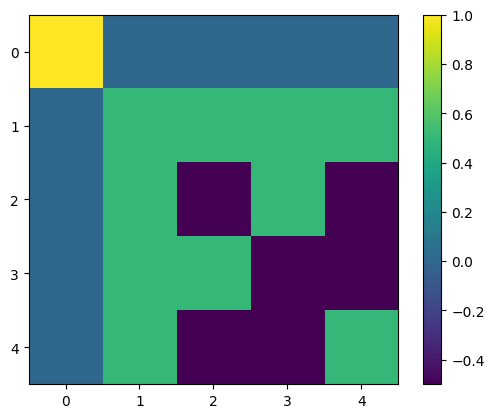

2 4
(-1.232595164407831e-32+1.5094937227365557e-48j) (-0.5+1.232595164407831e-32j)
(-2.465190328815662e-32+3.0189874454731115e-48j) (2.465190328815662e-32+1j)
4 2
[[ 1. -0.j  0. -0.j -0. +0.j  0. -0.j  0.5-0.j]
 [ 0. +0.j  0.5-0.j  0.5+0.j  0.5-0.j  0.5-0.j]
 [-0. +0.j  0.5+0.j -0.5-0.j  0.5-0.j  0. -0.j]
 [ 0. +0.j  0.5+0.j  0.5+0.j -0.5-0.j -0.5+0.j]
 [ 0. +0.j  0.5+0.j -0.5-0.j -0.5+0.j  0.5+0.j]]
3 2
[[ 1. -0.j  0. -0.j -0. +0.j -0.5+0.j  0.5-0.j]
 [ 0. +0.j  0.5-0.j  0.5+0.j  0.5-0.j  0.5-0.j]
 [-0. +0.j  0.5+0.j -0.5-0.j -0. +0.j  0. -0.j]
 [ 0. +0.j  0.5+0.j  0.5+0.j -0.5-0.j -0.5+0.j]
 [ 0. +0.j  0.5+0.j -0.5-0.j -0.5+0.j  0.5+0.j]]
2 2
[[ 1. -0.j  0. -0.j  0.5+0.j -0.5+0.j  0.5-0.j]
 [ 0. +0.j  0.5-0.j  0.5+0.j  0.5-0.j  0.5-0.j]
 [-0. +0.j  0.5+0.j  0. -0.j -0. +0.j  0. -0.j]
 [ 0. +0.j  0.5+0.j  0.5+0.j -0.5-0.j -0.5+0.j]
 [ 0. +0.j  0.5+0.j -0.5-0.j -0.5+0.j  0.5+0.j]]
1 2
[[ 1. -0.j -0.5-0.j  0.5+0.j -0.5+0.j  0.5-0.j]
 [ 0. +0.j  0.5-0.j  0.5+0.j  0.5-0.j  0.5-0.j]
 [-0. 

In [13]:
import numpy as np
import math  # For np.hypot
from scipy.linalg import expm
import matplotlib.pyplot as plt

# -------------------------------
# 1. Functions to build the unitary
# -------------------------------
def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    theta = np.pi * np.array(f)
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        # In the original scheme the phase was given by fix flag * π.
        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def unitary_fitted(couplings, rabi_freqs, fractions_fit, phases_fit, dim):
    """
    Similar to unitary(), but now the phase for each pulse is taken directly
    from the fitted phase (rather than a fixed flag multiplied by π).
    """
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, f_fit, phi_fit) in zip(couplings, rabi_freqs, fractions_fit, phases_fit):
        i, j = levels
        H_op = coupling_operator_with_phase(i, j, dim, phi_fit)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(f_fit, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def fix_couplings_and_phases(couplings, fixed_phase_flags):
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl
        if i != 0 and j == 0:
            cpl_fixed = (0, i)
            phase_flag_fixed = phase_flag + 1.0
        else:
            cpl_fixed = cpl
            phase_flag_fixed = phase_flag
        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags

# -------------------------------
# 2. QR decomposition using bus-only Givens rotations
#    in the order of the couplings list
# -------------------------------
def qr_decomposition_givens_bus_ordered(A, couplings):
    m, n = A.shape
    R = A.copy().astype(complex)
    rotations = []
    
    # Extract the target rows in the order given by the couplings list.
    # (Here we do not remove duplicates so that each pulse is fitted.)
    target_order = []
    for cpl in couplings:
        _, target = cpl
        target_order.append(target)

    for target in target_order:
        for j in range(n)[::-1]:
            # Here we always perform a rotation (even if the element is small) for fitting.
            if np.abs(R[target, j]) < 1e-95:
                continue
            a = R[0, j]
            b = R[target, j]
            r = np.hypot(np.abs(a), np.abs(b))
            print(target,j)
            print(a,b)
            if r < 1e-95:
                continue
            c = a / r
            s = (b / r)/(1j)
            print(c,s)
            rotations.append((0, target, c, s))
            # Apply the rotation to all columns j onward.
            for k in range(0, n)[::-1]:
                print(k,target)
                x = R[0, k]
                y = R[target, k]
                R[0, k] = c * x + 1j*s * y
                R[target, k] = 1*( -1j*(s.conjugate() * x + c * y))
                print(np.round(R,3))
            # Force numerical zero for stability.
            R[target, j] = 0.0
            # print(np.round(R,3))
            # Once a rotation has been applied for this target row, move to the next.
            break
   
    return rotations, R

# -------------------------------
# 3. Fitting pulse parameters from Givens rotations
# -------------------------------
def fit_parameters_from_givens(rotations):

    fractions_fit = []
    phases_fit = []
    for (pivot, target, c, s) in rotations:
        # Ideally, c should equal cos(α). We assume c is (nearly) real.
        # Clip c to [-1,1] in case of small numerical error.
        c_real = np.clip(np.real(c), -1.0, 1.0)
        alpha = np.arccos(c_real)
        # f is defined by: α = (π/2)*f  ==> f = 2α/π
        f_fit = 2 * alpha / np.pi
        # Now from s = i * exp(-iφ) sin(α), solve for φ.
        sin_alpha = np.sin(alpha)
        if np.abs(sin_alpha) < 1e-32:
            phi_fit = 0.0
        else:
            ratio = s / (1j * sin_alpha)  # ratio should equal exp(-iφ)
            phi_fit = -np.angle(ratio)
        fractions_fit.append(f_fit)
        phases_fit.append(phi_fit)
    return fractions_fit, phases_fit


dim = 5
init_state = np.array([0, 0, 1, 0, 0])

# Define the original pulse parameters.
couplings = [(0, 2), (0, 3), (0, 1), (0, 4), (0, 1), (0, 3), (0, 2)]
fractions = [1,
             1.5,
             2.0 * np.arcsin(np.sqrt(1/3)) / np.pi,
             2/3,
             2.0 * np.arcsin(np.sqrt(1/3)) / np.pi,
             0.5,
             1]
fixed_phase_flags = [0, 1, 0, 1, 0, 1, 1]
rabi_freqs = [1, 1, 1, 1, 1, 1, 1]

# dim =3
# init_state = np.array([0,1,0])
# couplings = [(2,0),(0,1),(2,0)]
# fractions = [1,1/2,1]#[np.sin(1)**2]  
# rabi_freqs = [1,1,1]      
# fixed_phase_flags = [0.5,0.5,0.5] 

couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
print("Fixed Couplings and Phase Flags:")
print(couplings, fixed_phase_flags)

A2 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)

A2 = np.array([[0.354-0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,
   0.354+0.j,  0.354+0.j,  0.354+0.j],
 [0.354-0.j, -0.354+0.j,  0.354+0.j, -0.354-0.j,  0.354+0.j,
  -0.354-0.j,  0.354+0.j, -0.354-0.j],
 [0.354-0.j,  0.354-0.j, -0.354-0.j, -0.354+0.j,  0.354+0.j,
   0.354+0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j,  0.354+0.j,
  -0.354-0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j,  0.354-0.j,  0.354-0.j,  0.354-0.j, -0.354-0.j,
  -0.354-0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j, -0.354+0.j,
   0.354+0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j, 0.354-0.j, -0.354+0.j, -0.354+0.j, -0.354+0.j,
  -0.354+0.j,  0.354+0.j, 0.354+0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j,
   0.354+0.j,  0.354+0.j, -0.354+0.j]],  dtype=complex)

print("\nTarget Unitary (rounded):")
print(np.round(A2, 3))
plt.imshow(np.real(A2))
plt.colorbar()
plt.show()
couplings_test = [(0, 2), (0, 3), (0, 1), (0, 4), (0, 1), (0, 3), (0, 2)]
givens_params, R_matrix = qr_decomposition_givens_bus_ordered(A2, couplings_test)

print("\nNumber of Givens rotations:", len(givens_params))
print("\nGivens Rotation Parameters (0, target, c, s):")
for idx, params in enumerate(givens_params):
    j, i_row, c, s = params
    print(f"  G{idx+1}: rows=({j}, {i_row}), c={np.round(c,3)}, s={np.round(s,3)}")

print("\nResulting Upper Triangular Matrix R:")
print(np.round(R_matrix, 3))

fractions_fit, phases_fit = fit_parameters_from_givens(givens_params)
print("\nFitted Fractions:")
print(np.round(fractions_fit, 4))
print("Fitted Phases (radians):")
print(np.round(phases_fit, 4))

U_fitted = unitary_fitted(couplings, rabi_freqs, fractions_fit, phases_fit, dim)
print("\nReconstructed Unitary from fitted parameters (rounded):")
print(np.round(U_fitted, 3))
print("\n--- Verification ---")

G_total = np.eye(A2.shape[0], dtype=complex)
for params in givens_params:
    j, i, c, s = params
    G_k = np.eye(A2.shape[0], dtype=complex)
    G_k[j, j] = c.conjugate()
    G_k[j, i] = s.conjugate()
    G_k[i, j] = -s
    G_k[i, i] = c
    G_total = G_k @ G_total
R_reconstructed = G_total @ A2
print("|| (G_k ... G_1 @ A) - R || =", np.linalg.norm(R_reconstructed - R_matrix))

Q_reconstructed = np.eye(A2.shape[0], dtype=complex)
for params in reversed(givens_params):
    j, i, c, s = params
    Gk_H = np.eye(A2.shape[0], dtype=complex)
    Gk_H[j, j] = c
    Gk_H[j, i] = -s.conjugate()
    Gk_H[i, j] = s
    Gk_H[i, i] = c.conjugate()
    Q_reconstructed = Gk_H @ Q_reconstructed
A_reconstructed = Q_reconstructed @ R_matrix
print("|| (Q @ R) - A || =", np.linalg.norm(A_reconstructed - A2))
if np.allclose(A2 @ A2.conj().T, np.eye(dim)):
    print("|| Q @ Q^H - I || =", np.linalg.norm(Q_reconstructed @ Q_reconstructed.conj().T - np.eye(dim)))


In [38]:
import numpy as np

def givens_rotation(m, j, theta):

    G = np.eye(m)
    c = np.cos(theta)
    s = np.sin(theta)
    G[0, 0] = c
    G[0, j] = s
    G[j, 0] = -s
    G[j, j] = c
    return G

def star_qr_decomposition(order, U, tol=1e-10):
    
    m = U.shape[0]
    rotations_info = []  
    rotation_mats = []     
    V = U.copy()          
    

    col = 0

    for i in order[::-1]:#range(m-1, 0,-1):
        a = V[0, col]
        b = V[i, col]
        if np.abs(b) < tol:
            continue
        theta = np.arctan2(b, a)
        G = givens_rotation(m, i, theta)
        V = G @ V
        rotations_info.append(("rotate_left", i, theta, col))
        rotation_mats.append(G)
    

    for col in order[::-1]:#range(1, m):
        theta_swap = np.pi / 2
        G_swap = givens_rotation(m, col, theta_swap)
        V = G_swap @ V
        rotations_info.append(("swap_left", col, theta_swap, col))
        rotation_mats.append(G_swap)
        
        for i in order:#range(1, m):
            a = V[0, col]
            b = V[i, col]
            if np.abs(b) < tol:
                continue
            theta = np.arctan2(b, a)
            G = givens_rotation(m, i, theta)
            V = G @ V
            rotations_info.append(("rotate_left", i, theta, col))
            rotation_mats.append(G)

        V = G_swap @ V   
        rotations_info.append(("swap_left_back", col, theta_swap, col))
        rotation_mats.append(G_swap)
    
    return rotations_info, V, rotation_mats



# dim = 5
# init_state = np.array([0, 0, 1, 0, 0])

# couplings = [(0, 2), (0, 3), (0, 1), (0, 4), (0, 1), (0, 3), (0, 2)]
# fractions = [1,
#              1.5,
#              2.0 * np.arcsin(np.sqrt(1/3)) / np.pi,
#              2/3,
#              2.0 * np.arcsin(np.sqrt(1/3)) / np.pi,
#              0.5,
#              1]
# fixed_phase_flags = [0, 1, 0, 1, 0, 1, 1]
# rabi_freqs = [1, 1, 1, 1, 1, 1, 1]

dim = 8
# init_state = np.array([0,1,0,0,0,0,0,0,0])
# couplings = [(2,0),(0,1),(2,0)] + [(4,0),(3,0)]  + [(0,1),(3,0)] + [(0,2),(4,0)]\
#           + [(6,0),(0,5),(6,0)] + [(8,0),(7,0)]  + [(0,5),(7,0)] + [(6,0)]\
#           + [(0,2),(6,0)] + [(5,0),(0,1),(5,0)] + [(7,0),(0,3),(7,0)] + [(0,4),(8,0)]
# fractions = [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2,1]\
#           + [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2]\
#           + [1/2,1] + [1,1/2,1] + [1,1/2,1] + [1/2,1]
# rabi_freqs = [1,1,1]+[1,1]+[1,1]+[1,1]\
#            + [1,1,1]+[1,1]+[1,1]+[1,1]\
#            +[1,1]+[1,1,1]+[1,1,1]+[1,1,1]
# fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5,0.5]\
#                    +[0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5]\
#                    + [0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5]
    
# couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
# print("Fixed Couplings and Phase Flags:")
# print(couplings, fixed_phase_flags)

# U = np.real(unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim))

U = np.real(np.array([[0.354-0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,
   0.354+0.j,  0.354+0.j,  0.354+0.j],
 [0.354-0.j, -0.354+0.j,  0.354+0.j, -0.354-0.j,  0.354+0.j,
  -0.354-0.j,  0.354+0.j, -0.354-0.j],
 [0.354-0.j,  0.354-0.j, -0.354-0.j, -0.354+0.j,  0.354+0.j,
   0.354+0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j,  0.354+0.j,
  -0.354-0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j,  0.354-0.j,  0.354-0.j,  0.354-0.j, -0.354-0.j,
  -0.354-0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j, -0.354+0.j,
   0.354+0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j, 0.354-0.j, -0.354+0.j, -0.354+0.j, -0.354+0.j,
  -0.354+0.j,  0.354+0.j, 0.354+0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j,
   0.354+0.j,  0.354+0.j, -0.354+0.j]],  dtype=complex))

# U = np.real(np.array([
#     [0.5-0.j,  0.5+0.j,  0.5-0.j,  0.5-0.j],
#     [0.5+0.j, -0.5-0.j,  0.5-0.j, -0.5+0.j],
#     [0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j],
#     [0.5+0.j, -0.5-0.j, -0.5-0.j,  0.5+0.j]
# ], dtype=complex))

import itertools

my_list = [1,2,3,4,5,6,7]
permutations = list(itertools.permutations(my_list))

list_comp = []
len_comp = 36
for order in permutations:
    # print(order)
    rotations_info, V_triangular, rotation_mats = star_qr_decomposition(order,U)
    compressed = compress_rotations(rotation_mats)
    coup, f, ph = inverse_single_pulse(compressed[13])
    print(f)
    # if len(compressed) < len_comp:
    #     print(len(compressed))
    list_comp.append(compressed)
        # len_comp = len(compressed)

# Display the sequence of rotations.
    # print("Sequence of rotations (each tuple: (operation, index, theta, column)):")
    # for op in rotations_info:
    #     print(op)
    
    # print("\nFinal matrix after applying rotations (ideally diagonal):")
    # np.set_printoptions(precision=3, suppress=True)
    # print(V_triangular)
    
    # U_reconstructed = np.eye(dim)
    # for G in reversed(rotation_mats):
    #     U_reconstructed = G.T @ U_reconstructed
    
    # print("\nReconstructed U from the rotation matrices (should match the original U):")
    # print(U_reconstructed)


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.6081734479693928
1.6081734479693928
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.6081734479693928
1.6081734479693928
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.608173447969393
1.608173447969393
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.608173447969393
1.608173447969393
1.0
1.0
1.0
1.0
1.0
1.0
1.6666666666666667
1.6666666666666667
1.0
1.0
1.0
1.0
1.6666666666666667
1.6666666666666667
1.0
1.0
1.0
1.0
1.6666666666666667
1.6666666666666667
0.3918265520306073
0.3918265520306073
0.3918265520

In [ ]:
import numpy as np

def detect_adjacent_same_couplings(rotation_mats, tol=1e-8):
    """
    Detect where adjacent rotation matrices act on the same pair of levels.

    Assumes each matrix in `rotation_mats` is a unitary generated by a pulse
    that couples level 0 with some other level j.

    Parameters
    ----------
    rotation_mats : list of (dim, dim) np.ndarray
        List of unitary matrices for individual pulses.

    Returns
    -------
    matches : list of int
        List of 0 or 1 where 1 indicates adjacent couplings act on the same (0, j).
        Length is len(rotation_mats) - 1.
    """
    matches = []
    for U1, U2 in zip(rotation_mats[:-1], rotation_mats[1:]):
        # Find which level (other than 0) this pulse couples with
        def find_coupled_level(U):
            for j in range(1, U.shape[0]):
                if np.abs(U[0, j]) > tol or np.abs(U[j, 0]) > tol:
                    return j
            return None

        j1 = find_coupled_level(U1)
        j2 = find_coupled_level(U2)

        matches.append(int(j1 == j2 and j1 is not None))

    return matches

import numpy as np
from numpy.linalg import norm

def compress_rotations(rotation_mats, tol=1e-8):
    """
    Optimize a sequence of rotations by combining adjacent ones acting on the same subspace.

    Parameters
    ----------
    rotation_mats : list of (dim, dim) np.ndarray
        List of unitary matrices representing individual pulses.

    Returns
    -------
    optimized_mats : list of np.ndarray
        Compressed list with redundant or canceling rotations removed.
    """
    i = 0
    optimized = []
    while i < len(rotation_mats):
        if i + 1 < len(rotation_mats):
            U1 = rotation_mats[i]
            U2 = rotation_mats[i+1]

            # Check if both couple the same (0, j)
            def find_coupled(U):
                for j in range(1, U.shape[0]):
                    if np.abs(U[0, j]) > tol or np.abs(U[j, 0]) > tol:
                        return j
                return None

            j1 = find_coupled(U1)
            j2 = find_coupled(U2)

            if j1 == j2 and j1 is not None:
                combined = U2 @ U1  # Order matters!
                if norm(combined - np.eye(U1.shape[0])) < tol:
                    # Cancels out → skip both
                    i += 2
                    continue
                else:
                    # Replace with combined
                    optimized.append(combined)
                    i += 2
                    continue

        # Default: keep current
        optimized.append(rotation_mats[i])
        i += 1

    return optimized

import numpy as np
from numpy.linalg import norm
from math import acos, pi

def inverse_single_pulse(U, *, tol= 1e-8):
    """
    Infer (i, j, fraction f, phase φ) for a unitary generated by ONE pulse of the form

        U = exp[‑i (Ω t /2) ( |i⟩⟨j| e^{+iφ} + |j⟩⟨i| e^{-iφ} )]

    Parameters
    ----------
    U   : (dim, dim) unitary ndarray
    tol : numerical tolerance for zero / equality tests

    Returns
    -------
    coupling  : tuple  (i, j)
    fraction  : float  f  (θ = π f,  0 ≤ f ≤ 2)
    phase     : float  φ  in the range 0 ≤ φ < 2π

    Raises
    ------
    ValueError if `U` is not compatible with a single pulse.
    """
    
    U = np.asarray(U)
    dim = U.shape[0]

    # --- locate the only non‑trivial 2×2 block -----------------------------
    cand = [(p, q) for p in range(dim) for q in range(p+1, dim)
            if abs(U[p, q]) > tol or abs(U[q, p]) > tol]

    if len(cand) != 1:
        # raise ValueError("The matrix is not generated by a single two‑level pulse.")
        return None, None, None

    i, j = cand[0]

    # everything outside rows/cols i,j must look like the identity
    mask = np.ones_like(U, dtype=bool)
    mask[[i, j], :] = False
    mask[:, [i, j]] = False
    if norm(U[mask] - np.eye(dim)[mask]) > tol:
        raise ValueError("Extra couplings detected – not a single pulse.")

    # --- extract rotation angle θ and phase φ -----------------------------
    c = U[i, i].real          # should equal U[j, j] and be real
    if abs(U[j, j].real - c) > tol or abs(U[i, i].imag) > tol or abs(U[j, j].imag) > tol:
        raise ValueError("Diagonal elements are inconsistent with a single pulse.")

    # numerical safety
    c = max(min(c, 1.0), -1.0)
    theta = 2 * acos(c)       # θ  (0 ≤ θ ≤ 2π)
    fraction = theta / pi

    # off‑diagonal element gives φ   (U_ij = –i sin(θ/2) e^{+iφ})
    u_ij = U[i, j]
    if abs(u_ij) < tol:
        raise ValueError("Zero off‑diagonal element – ambiguous phase.")
    phi = (np.angle(u_ij) + pi/2) % (2*pi)   # shift removes the –i factor

    return (i, j), fraction, phi

def givens_rotation(m, j, theta):

    G = np.eye(m)
    c = np.cos(theta)
    s = np.sin(theta)
    G[0, 0] = c
    G[0, j] = s
    G[j, 0] = -s
    G[j, j] = c
    return G

def star_qr_decomposition(order, U, tol=1e-10):
    
    m = U.shape[0]
    rotations_info = []  
    rotation_mats = []     
    V = U.copy()          
    

    col = 0

    for i in order[::-1]:#range(m-1, 0,-1):
        a = V[0, col]
        b = V[i, col]
        if np.abs(b) < tol:
            continue
        theta = np.arctan2(b, a)
        G = givens_rotation(m, i, theta)
        V = G @ V
        rotations_info.append(("rotate_left", i, theta, col))
        rotation_mats.append(G)
    

    for col in order:#range(1, m):
        theta_swap = np.pi / 2
        G_swap = givens_rotation(m, col, theta_swap)
        V = G_swap @ V
        rotations_info.append(("swap_left", col, theta_swap, col))
        rotation_mats.append(G_swap)
        
        for i in order:#range(1, m):
            a = V[0, col]
            b = V[i, col]
            if np.abs(b) < tol:
                continue
            theta = np.arctan2(b, a)
            G = givens_rotation(m, i, theta)
            V = G @ V
            rotations_info.append(("rotate_left", i, theta, col))
            rotation_mats.append(G)

        V = G_swap @ V   
        rotations_info.append(("swap_left_back", col, theta_swap, col))
        rotation_mats.append(G_swap)
    
    return rotations_info, V, rotation_mats



# dim = 5
# init_state = np.array([0, 0, 1, 0, 0])

# couplings = [(0, 2), (0, 3), (0, 1), (0, 4), (0, 1), (0, 3), (0, 2)]
# fractions = [1,
#              1.5,
#              2.0 * np.arcsin(np.sqrt(1/3)) / np.pi,
#              2/3,
#              2.0 * np.arcsin(np.sqrt(1/3)) / np.pi,
#              0.5,
#              1]
# fixed_phase_flags = [0, 1, 0, 1, 0, 1, 1]
# rabi_freqs = [1, 1, 1, 1, 1, 1, 1]

dim = 8
# init_state = np.array([0,1,0,0,0,0,0,0,0])
# couplings = [(2,0),(0,1),(2,0)] + [(4,0),(3,0)]  + [(0,1),(3,0)] + [(0,2),(4,0)]\
#           + [(6,0),(0,5),(6,0)] + [(8,0),(7,0)]  + [(0,5),(7,0)] + [(6,0)]\
#           + [(0,2),(6,0)] + [(5,0),(0,1),(5,0)] + [(7,0),(0,3),(7,0)] + [(0,4),(8,0)]
# fractions = [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2,1]\
#           + [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2]\
#           + [1/2,1] + [1,1/2,1] + [1,1/2,1] + [1/2,1]
# rabi_freqs = [1,1,1]+[1,1]+[1,1]+[1,1]\
#            + [1,1,1]+[1,1]+[1,1]+[1,1]\
#            +[1,1]+[1,1,1]+[1,1,1]+[1,1,1]
# fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5,0.5]\
#                    +[0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5]\
#                    + [0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5]
    
# couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
# print("Fixed Couplings and Phase Flags:")
# print(couplings, fixed_phase_flags)

# U = np.real(unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim))

U = np.real(np.array([[0.354-0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,
   0.354+0.j,  0.354+0.j,  0.354+0.j],
 [0.354-0.j, -0.354+0.j,  0.354+0.j, -0.354-0.j,  0.354+0.j,
  -0.354-0.j,  0.354+0.j, -0.354-0.j],
 [0.354-0.j,  0.354-0.j, -0.354-0.j, -0.354+0.j,  0.354+0.j,
   0.354+0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j,  0.354+0.j,
  -0.354-0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j,  0.354-0.j,  0.354-0.j,  0.354-0.j, -0.354-0.j,
  -0.354-0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j, -0.354+0.j,
   0.354+0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j, 0.354-0.j, -0.354+0.j, -0.354+0.j, -0.354+0.j,
  -0.354+0.j,  0.354+0.j, 0.354+0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j,
   0.354+0.j,  0.354+0.j, -0.354+0.j]],  dtype=complex))

U = np.real(np.array([
    [0.5-0.j,  0.5+0.j,  0.5-0.j,  0.5-0.j],
    [0.5+0.j, -0.5-0.j,  0.5-0.j, -0.5+0.j],
    [0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j],
    [0.5+0.j, -0.5-0.j, -0.5-0.j,  0.5+0.j]
], dtype=complex))

import itertools

my_list = [1,2,3]
permutations = list(itertools.permutations(my_list))

list_comp = []
len_comp = 36
for order in permutations:
    # print(order)
    rotations_info, V_triangular, rotation_mats = star_qr_decomposition(order,U)
    compressed = compress_rotations(rotation_mats)
    # coup, f, ph = inverse_single_pulse(compressed[13])
    # print(f)
    if len(compressed) < len_comp:
        print(len(compressed))
        # list_comp.append(compressed)
        len_comp = len(compressed)
    couplings = []
    phases = []
    fractions = []
    # print(len(rotation_mats))
    for r in compressed:
        coupling, f, phi = inverse_single_pulse(r)
        couplings.append(coupling)
        fractions.append(f)
        phases.append(phi)
    # if couplings[0:6]==couplings[7:13][::-1]:
    if 3%np.round(fractions[0],2) == 0 and 3%np.round(fractions[4],2) == 0:   
        print(couplings)
# Display the sequence of rotations.
    # print("Sequence of rotations (each tuple: (operation, index, theta, column)):")
    # for op in rotations_info:
    #     print(op)
    
    # print("\nFinal matrix after applying rotations (ideally diagonal):")
    # np.set_printoptions(precision=3, suppress=True)
    # print(V_triangular)
    
    # U_reconstructed = np.eye(dim)
    # for G in reversed(rotation_mats):
    #     U_reconstructed = G.T @ U_reconstructed
    
    # print("\nReconstructed U from the rotation matrices (should match the original U):")
    # print(U_reconstructed)


In [41]:
x = [(0, 4), (0, 2), (0, 5), (0, 3), (0, 6), (0, 7), (0, 1), (0, 7), (0, 6), (0, 3), (0, 5), (0, 2), (0, 4)]
print(x[12])

(0, 4)


In [12]:
print(np.round(list_comp[-1],3))

[[[ 0.707  0.     0.    ...  0.     0.     0.   ]
  [ 0.     1.     0.    ...  0.     0.     0.   ]
  [ 0.     0.     1.    ...  0.     0.     0.   ]
  ...
  [ 0.     0.     0.    ...  1.     0.     0.   ]
  [ 0.     0.     0.    ...  0.     1.     0.   ]
  [ 0.     0.     0.    ...  0.     0.     1.   ]]

 [[ 0.816  0.     0.577 ...  0.     0.     0.   ]
  [ 0.     1.     0.    ...  0.     0.     0.   ]
  [-0.577  0.     0.816 ...  0.     0.     0.   ]
  ...
  [ 0.     0.     0.    ...  1.     0.     0.   ]
  [ 0.     0.     0.    ...  0.     1.     0.   ]
  [ 0.     0.     0.    ...  0.     0.     1.   ]]

 [[ 0.866  0.     0.    ...  0.5    0.     0.   ]
  [ 0.     1.     0.    ...  0.     0.     0.   ]
  [ 0.     0.     1.    ...  0.     0.     0.   ]
  ...
  [-0.5    0.     0.    ...  0.866  0.     0.   ]
  [ 0.     0.     0.    ...  0.     1.     0.   ]
  [ 0.     0.     0.    ...  0.     0.     1.   ]]

 ...

 [[ 0.     0.     0.    ...  1.     0.     0.   ]
  [ 0.     1.     0.

In [4]:
def detect_adjacent_same_couplings(rotation_mats, tol=1e-8):
    """
    Detect where adjacent rotation matrices act on the same pair of levels.

    Assumes each matrix in `rotation_mats` is a unitary generated by a pulse
    that couples level 0 with some other level j.

    Parameters
    ----------
    rotation_mats : list of (dim, dim) np.ndarray
        List of unitary matrices for individual pulses.

    Returns
    -------
    matches : list of int
        List of 0 or 1 where 1 indicates adjacent couplings act on the same (0, j).
        Length is len(rotation_mats) - 1.
    """
    matches = []
    for U1, U2 in zip(rotation_mats[:-1], rotation_mats[1:]):
        # Find which level (other than 0) this pulse couples with
        def find_coupled_level(U):
            for j in range(1, U.shape[0]):
                if np.abs(U[0, j]) > tol or np.abs(U[j, 0]) > tol:
                    return j
            return None

        j1 = find_coupled_level(U1)
        j2 = find_coupled_level(U2)

        matches.append(int(j1 == j2 and j1 is not None))

    return matches

import numpy as np
from numpy.linalg import norm

def compress_rotations(rotation_mats, tol=1e-8):
    """
    Optimize a sequence of rotations by combining adjacent ones acting on the same subspace.

    Parameters
    ----------
    rotation_mats : list of (dim, dim) np.ndarray
        List of unitary matrices representing individual pulses.

    Returns
    -------
    optimized_mats : list of np.ndarray
        Compressed list with redundant or canceling rotations removed.
    """
    i = 0
    optimized = []
    while i < len(rotation_mats):
        if i + 1 < len(rotation_mats):
            U1 = rotation_mats[i]
            U2 = rotation_mats[i+1]

            # Check if both couple the same (0, j)
            def find_coupled(U):
                for j in range(1, U.shape[0]):
                    if np.abs(U[0, j]) > tol or np.abs(U[j, 0]) > tol:
                        return j
                return None

            j1 = find_coupled(U1)
            j2 = find_coupled(U2)

            if j1 == j2 and j1 is not None:
                combined = U2 @ U1  # Order matters!
                if norm(combined - np.eye(U1.shape[0])) < tol:
                    # Cancels out → skip both
                    i += 2
                    continue
                else:
                    # Replace with combined
                    optimized.append(combined)
                    i += 2
                    continue

        # Default: keep current
        optimized.append(rotation_mats[i])
        i += 1

    return optimized

    
compressed = compress_rotations(rotation_mats)

print(f"Original pulse count: {len(rotation_mats)}")
compressed

Original pulse count: 39


[array([[ 0.70710678,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.70710678],
        [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          1.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  1.        ,  0.        ],
        [-0.70710678,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.70710678]]),
 array([[ 0.81

In [329]:
def commutation_analysis(rotation_mats, tol=1e-8):
    """
    Check commutation and anticommutation between adjacent unitary rotations.

    Parameters
    ----------
    rotation_mats : list of np.ndarray
        Sequence of unitary matrices.

    Returns
    -------
    commutes : list of int
        1 if U[i] and U[i+1] commute, else 0.
    anticommutes : list of int
        1 if U[i] and U[i+1] anticommute, else 0.
    """
    commutes = []
    anticommutes = []

    for U1, U2 in zip(rotation_mats[:-1], rotation_mats[1:]):
        commutator = U1 @ U2 - U2 @ U1
        anticommutator = U1 @ U2 + U2 @ U1

        commutes.append(int(np.linalg.norm(commutator) < tol))
        anticommutes.append(int(np.linalg.norm(anticommutator) < tol))

    return commutes, anticommutes
commutes, anticommutes = commutation_analysis(rotation_mats)

print("Commutation flags:   ", commutes)
print("Anticommutation flags:", anticommutes)


Commutation flags:    [0, 0, 1, 0, 0, 0, 0, 0, 0, 1]
Anticommutation flags: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [30]:
import numpy as np
from numpy.linalg import norm
from math import acos, pi

def inverse_single_pulse(U, *, tol= 1e-8):
    """
    Infer (i, j, fraction f, phase φ) for a unitary generated by ONE pulse of the form

        U = exp[‑i (Ω t /2) ( |i⟩⟨j| e^{+iφ} + |j⟩⟨i| e^{-iφ} )]

    Parameters
    ----------
    U   : (dim, dim) unitary ndarray
    tol : numerical tolerance for zero / equality tests

    Returns
    -------
    coupling  : tuple  (i, j)
    fraction  : float  f  (θ = π f,  0 ≤ f ≤ 2)
    phase     : float  φ  in the range 0 ≤ φ < 2π

    Raises
    ------
    ValueError if `U` is not compatible with a single pulse.
    """
    
    U = np.asarray(U)
    dim = U.shape[0]

    # --- locate the only non‑trivial 2×2 block -----------------------------
    cand = [(p, q) for p in range(dim) for q in range(p+1, dim)
            if abs(U[p, q]) > tol or abs(U[q, p]) > tol]

    if len(cand) != 1:
        # raise ValueError("The matrix is not generated by a single two‑level pulse.")
        return None, None, None

    i, j = cand[0]

    # everything outside rows/cols i,j must look like the identity
    mask = np.ones_like(U, dtype=bool)
    mask[[i, j], :] = False
    mask[:, [i, j]] = False
    if norm(U[mask] - np.eye(dim)[mask]) > tol:
        raise ValueError("Extra couplings detected – not a single pulse.")

    # --- extract rotation angle θ and phase φ -----------------------------
    c = U[i, i].real          # should equal U[j, j] and be real
    if abs(U[j, j].real - c) > tol or abs(U[i, i].imag) > tol or abs(U[j, j].imag) > tol:
        raise ValueError("Diagonal elements are inconsistent with a single pulse.")

    # numerical safety
    c = max(min(c, 1.0), -1.0)
    theta = 2 * acos(c)       # θ  (0 ≤ θ ≤ 2π)
    fraction = theta / pi

    # off‑diagonal element gives φ   (U_ij = –i sin(θ/2) e^{+iφ})
    u_ij = U[i, j]
    if abs(u_ij) < tol:
        raise ValueError("Zero off‑diagonal element – ambiguous phase.")
    phi = (np.angle(u_ij) + pi/2) % (2*pi)   # shift removes the –i factor

    return (i, j), fraction, phi
U_demo = np.array([[ 0.707, 0,  0.707, 0, 0],
                   [ 0.   , 1,  0.   , 0, 0],
                   [-0.707, 0,  0.707, 0, 0],
                   [ 0.   , 0,  0.   , 1, 0],
                   [ 0.   , 0,  0.   , 0, 1]])
couplings = []
phases = []
fractions = []
print(len(rotation_mats))
for comps in list_comp:
    for r in comps:
        coupling, f, phi = inverse_single_pulse(r)
        couplings.append(coupling)
        fractions.append(f)
        phases.append(phi)
        # print("coupling =", coupling)
        # print("fraction =", f)
        # print("phase    =", phi/np.pi)
    print(fractions[10])

37
0.4195693767448337
0.4195693767448337
0.4195693767448337
0.4195693767448337
0.4195693767448337


In [16]:
print('couplings  = ', couplings)
print('fractions = ', fractions)
print('phases = ', phases)

couplings  =  [(0, 4), (0, 2), (0, 5), (0, 3), (0, 6), (0, 7), (0, 1), (0, 7), (0, 6), (0, 3), (0, 5), (0, 1), (0, 7), (0, 3), (0, 5), (0, 2), (0, 4), (0, 7), (0, 6), (0, 2), (0, 4), (0, 6), (0, 3), (0, 5), (0, 2), (0, 3), (0, 5), (0, 4), (0, 5)]
fractions =  [0.5, 0.3918265520306073, 0.33333333333333337, 0.2951672353008666, 0.26772047280122996, 0.24675171442884994, 1.230053456162616, 1.4543710516570103, 0.2677204728012301, 0.40966552939826684, 0.4195693767448337, 1.0, 1.0, 1.0, 0.435905783151025, 0.2163468959387855, 0.33333333333333326, 1.0, 1.0, 0.33333333333333326, 0.3918265520306073, 1.0, 1.0, 0.49999999999999983, 0.5, 1.0, 1.0, 0.5, 1.0]
phases =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 1.5, 0.5]


In [18]:
def detect_adjacent_same_couplings(rotation_mats, tol=1e-8):
    """
    Detect where adjacent rotation matrices act on the same pair of levels.

    Assumes each matrix in `rotation_mats` is a unitary generated by a pulse
    that couples level 0 with some other level j.

    Parameters
    ----------
    rotation_mats : list of (dim, dim) np.ndarray
        List of unitary matrices for individual pulses.

    Returns
    -------
    matches : list of int
        List of 0 or 1 where 1 indicates adjacent couplings act on the same (0, j).
        Length is len(rotation_mats) - 1.
    """
    matches = []
    for U1, U2 in zip(rotation_mats[:-1], rotation_mats[1:]):
        # Find which level (other than 0) this pulse couples with
        def find_coupled_level(U):
            for j in range(1, U.shape[0]):
                if np.abs(U[0, j]) > tol or np.abs(U[j, 0]) > tol:
                    return j
            return None

        j1 = find_coupled_level(U1)
        j2 = find_coupled_level(U2)

        matches.append(int(j1 == j2 and j1 is not None))

    return matches

import numpy as np
from numpy.linalg import norm

def compress_rotations(rotation_mats, tol=1e-8):
    """
    Optimize a sequence of rotations by combining adjacent ones acting on the same subspace.

    Parameters
    ----------
    rotation_mats : list of (dim, dim) np.ndarray
        List of unitary matrices representing individual pulses.

    Returns
    -------
    optimized_mats : list of np.ndarray
        Compressed list with redundant or canceling rotations removed.
    """
    i = 0
    optimized = []
    while i < len(rotation_mats):
        if i + 1 < len(rotation_mats):
            U1 = rotation_mats[i]
            U2 = rotation_mats[i+1]

            # Check if both couple the same (0, j)
            def find_coupled(U):
                for j in range(1, U.shape[0]):
                    if np.abs(U[0, j]) > tol or np.abs(U[j, 0]) > tol:
                        return j
                return None

            j1 = find_coupled(U1)
            j2 = find_coupled(U2)

            if j1 == j2 and j1 is not None:
                combined = U2 @ U1  # Order matters!
                if norm(combined - np.eye(U1.shape[0])) < tol:
                    # Cancels out → skip both
                    i += 2
                    continue
                else:
                    # Replace with combined
                    optimized.append(combined)
                    i += 2
                    continue

        # Default: keep current
        optimized.append(rotation_mats[i])
        i += 1

    return optimized

    
compressed = compress_rotations(rotation_mats)

print(f"Original pulse count: {len(rotation_mats)}")
compressed

Original pulse count: 37


[array([[ 0.70710678,  0.70710678,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [-0.70710678,  0.70710678,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          1.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  1.        ]]),
 array([[ 0.81

Fixed Couplings and Phase Flags:
[(0, 2), (0, 1), (0, 3), (0, 1), (0, 2), (0, 3)] [0.5, 0.5, 0.5, 1.5, 1.5, 0.5]

Target Unitary (rounded):
[[-0.5-0.j -0.5+0.j -0.5+0.j -0.5+0.j]
 [-0.5-0.j  0.5-0.j -0.5-0.j  0.5+0.j]
 [-0.5-0.j -0.5-0.j  0.5-0.j  0.5+0.j]
 [-0.5+0.j  0.5-0.j  0.5-0.j -0.5+0.j]]


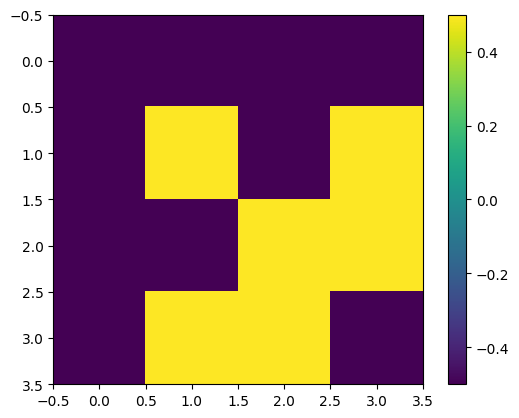

In [323]:
dim = 4
init_state = np.array([0, 0, 1, 0, 0])

couplings  =  [(0, 4), (0, 2), (0, 5), (0, 3), (0, 6), (0, 7), (0, 1), (0, 7), (0, 6), (0, 3), (0, 5), (0, 1), (0, 7), (0, 3), (0, 5), (0, 2), (0, 4), (0, 7), (0, 6), (0, 2), (0, 4), (0, 6), (0, 3), (0, 5), (0, 2), (0, 3), (0, 5), (0, 4), (0, 5)]
fractions =  [0.5, 0.3918265520306073, 0.33333333333333337, 0.2951672353008666, 0.26772047280122996, 0.24675171442884994, 1.230053456162616, 1.4543710516570103, 0.2677204728012301, 0.40966552939826684, 0.4195693767448337, 1.0, 1.0, 1.0, 0.435905783151025, 0.2163468959387855, 0.33333333333333326, 1.0, 1.0, 0.33333333333333326, 0.3918265520306073, 1.0, 1.0, 0.49999999999999983, 0.5, 1.0, 1.0, 0.5, 1.0]
phases =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 1.5, 0.5]

# couplings  =  [(0, 3), (0, 2), (0, 1), (0, 2), (0, 3)]
# fractions =  [0.5, 0.3918265520306073, 1.3333333333333333, 1.6081734479693928, 0.5000000000000001]
# phases =  [0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 0.5]

# couplings  =  [(0, 2), (0, 1), (0, 3), (0, 1), (0, 2), (0, 3)]
# fractions =  [0.5, 0.3918265520306073, 1.3333333333333333, 0.3918265520306073, 0.5000000000000001, 1.0]
# phases =  [0.5, 0.5, 0.5, 1.5, 1.5, 0.5]

fixed_phase_flags = phases
rabi_freqs = [1]*len(couplings)

couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
print("Fixed Couplings and Phase Flags:")
print(couplings, fixed_phase_flags)

# Build the target unitary using the original pulses.
A2 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
print("\nTarget Unitary (rounded):")
print(np.round(A2, 3))
plt.imshow(np.real(A2))
plt.colorbar()
plt.show()

In [ ]:
import numpy as np

def givens_rotation_matrix(m, i, j, theta):
    """Create a Givens rotation matrix G for size m that rotates rows i and j."""
    G = np.eye(m)
    c, s = np.cos(theta), np.sin(theta)
    G[[i, i, j, j], [i, j, i, j]] = c, -s, s, c
    return G

def givens_rotation_params(a, b):
    """Compute cosine and sine values for Givens rotation to zero out b."""
    r = np.hypot(a, b)
    if r == 0:
        return 1.0, 0.0
    return a/r, -b/r

def star_qr_givens(A, central_row=0, tol=1e-12):
    """Perform QR decomposition using Givens rotations in a star topology."""
    m, n = A.shape
    V = A.copy()
    rotations = []

    for col in range(n):
        for i in range(m - 1, -1, -1):  # From bottom up
            if i == central_row:
                continue
            a = V[central_row, col]
            b = V[i, col]
            if np.abs(b) < tol:
                continue

            theta = np.arctan2(b, a)
            G = givens_rotation_matrix(m, central_row, i, theta)
            V = G @ V
            rotations.append((central_row, i, theta))  # Store rotation info

    R = V
    return R, rotations


In [47]:
# Generate a random 8x8 matrix
np.random.seed(0)
A = np.random.randn(8, 8)

# Perform star QR decomposition
R, rotations = star_qr_givens(A)

# Print result
print("Upper triangular R matrix:")
print(np.round(R, 3))

print("\nGivens rotations applied (central, target, theta):")
for rot in rotations:
    print(rot)


Upper triangular R matrix:
[[ 0.702 -0.59   0.232 -2.001 -2.385  0.823  0.604 -0.47 ]
 [-1.972  1.059 -0.261 -0.561 -0.511 -1.67  -0.407 -0.698]
 [ 0.032 -1.42  -0.685 -0.455  0.387  0.844 -1.302 -0.506]
 [-2.249 -2.09  -1.315  1.045  0.926  0.295 -0.735  1.116]
 [-1.872  0.789  0.092 -0.411 -1.222 -0.047 -0.195  0.244]
 [-0.944 -0.134 -1.476  0.923 -2.316 -0.897 -0.858 -0.597]
 [ 0.448 -0.255  0.532 -0.447  0.632  1.012  0.304 -1.431]
 [-0.983  0.02  -0.724 -2.274 -1.098  0.788 -0.788 -0.111]]

Givens rotations applied (central, target, theta):
(0, 7, 0.03768920133339506)
(0, 6, -0.74203855379686)
(0, 5, -1.376034781095341)
(0, 4, -2.4099203695676095)
(0, 3, 1.508093670159618)
(0, 2, 2.5567150769927163)
(0, 1, -0.09739584803147347)
(0, 7, 2.8443218264177066)
(0, 6, -0.437097995599427)
(0, 5, -0.5781041342982988)
(0, 4, 1.4433781487863373)
(0, 3, -2.972326366228433)
(0, 2, 0.4075686039470679)
(0, 1, 0.29946744839080847)
(0, 7, 0.3529918060020175)
(0, 6, -0.8688983935851943)
(0, 5, -2.4